In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns
BATCH_SIZE = 64
SEED = 42
torch.manual_seed(SEED)

In [2]:
class CIFAR10Subset(Dataset):
    def __init__(self, dataset, classes):
        self.dataset = dataset
        self.classes = classes
        self.indices = [i for i, (_, label) in enumerate(self.dataset) if label in self.classes]
        self.labels_map = {cls: idx for idx, cls in enumerate(classes)}  # Map classes to new indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        img, label = self.dataset[original_idx]
        new_label = self.labels_map[label]
        return img, new_label


In [3]:
selected_classes=[0, 1,2]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to mean=0, std=1
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# training and testing datasets for selected classes
filtered_train_data = CIFAR10Subset(train_data, selected_classes)
filtered_test_data = CIFAR10Subset(test_data, selected_classes)

# now doing  Stratified random split (80-20) for training and validation
num_train_samples = int(0.8 * len(filtered_train_data))
num_val_samples = int(0.2 * len(filtered_train_data))

train_data_split, val_data_split = random_split(filtered_train_data, [num_train_samples, num_val_samples],
                                                generator=torch.Generator().manual_seed(42))


Files already downloaded and verified
Files already downloaded and verified


In [5]:
test_indices = []
class_counts = {cls: 0 for cls in selected_classes}
for i, (_, label) in enumerate(filtered_test_data):
    if class_counts[label] < 1000:
        test_indices.append(i)
        class_counts[label] += 1
        if all(count == 1000 for count in class_counts.values()):
            break
test_data_split = Subset(filtered_test_data, test_indices)

In [6]:
batch_size = 64

train_loader = DataLoader(train_data_split, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data_split, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data_split, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data_split)}")
print(f"Validation set size: {len(val_data_split)}")
print(f"Test set size: {len(test_data_split)}")

Train set size: 12000
Validation set size: 3000
Test set size: 3000


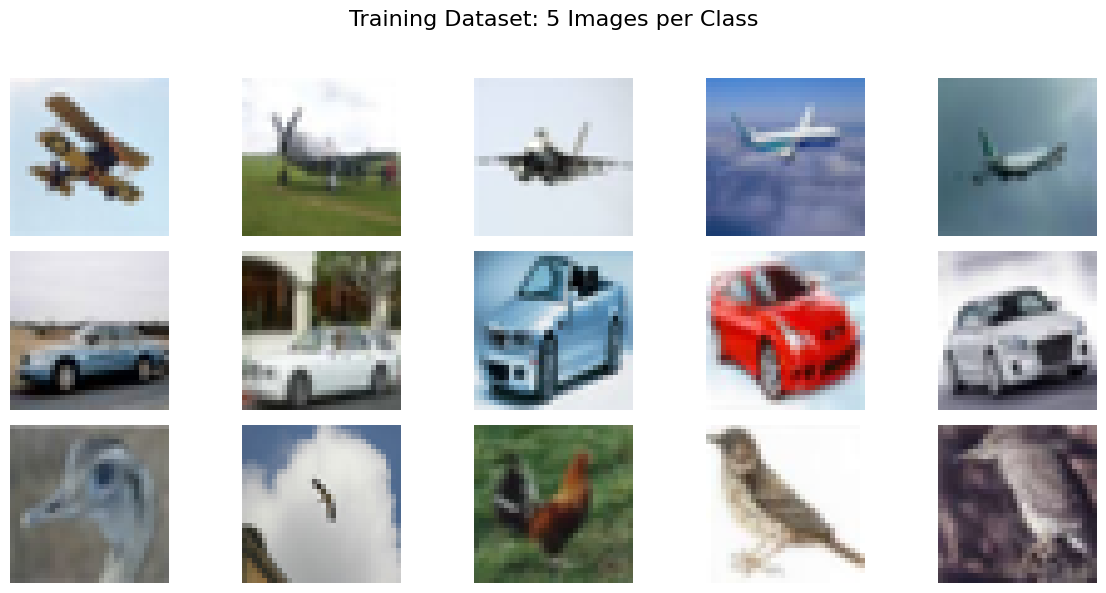

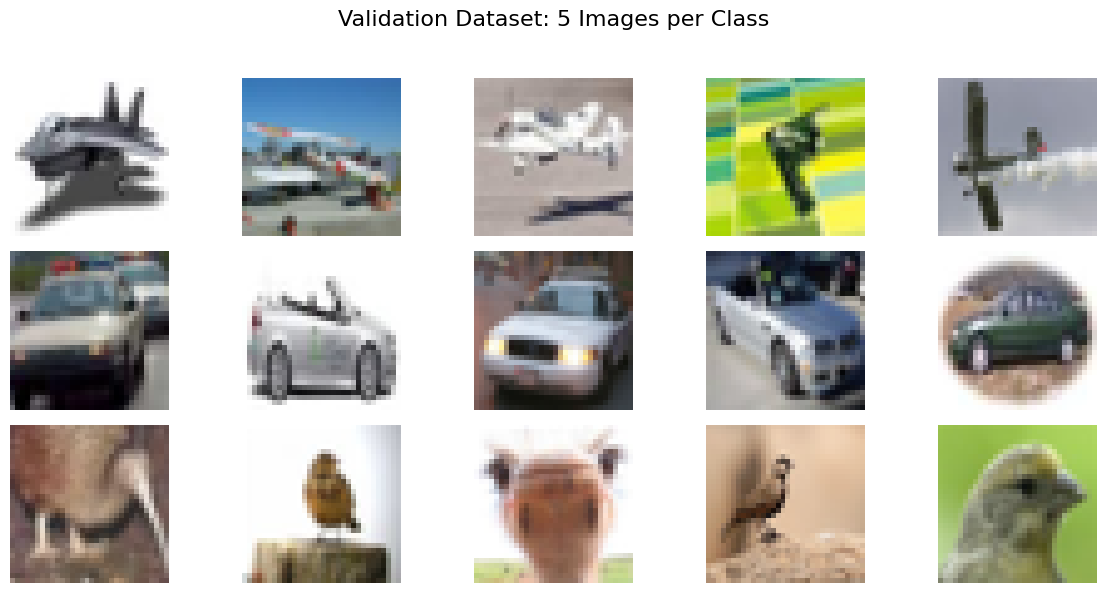

In [7]:
import matplotlib.pyplot as plt

def visualize_images(dataset, title):
    class_images = {cls: [] for cls in range(len(selected_classes))}
    
    
    for img, label in dataset:
        if len(class_images[label]) < 5: 
            class_images[label].append(img)
        flg=True
        for images in class_images.values():
            if len(images) < 5:
                flg=False
                break
        if flg: 
            break
    
    # Plot images
    fig, axes = plt.subplots(len(selected_classes), 5, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)
    
    for cls, images in class_images.items():
        for i, img in enumerate(images):
            ax = axes[cls, i]
            img = img.permute(1, 2, 0)  
            img = (img * 0.5 + 0.5).numpy() 
            ax.imshow(img)
            ax.axis('off')
            if i == 0:
                ax.set_ylabel(f"Class {cls}", fontsize=12)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

visualize_images(train_data_split, "Training Dataset: 5 Images per Class")
visualize_images(val_data_split, "Validation Dataset: 5 Images per Class")

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1= nn.Conv2d(in_channels=3 , out_channels=16, kernel_size = 5, stride= 1 , padding= 1)
        self.pool_1 = nn.MaxPool2d(kernel_size =3, stride=2)
        self.conv2= nn.Conv2d(in_channels=16 , out_channels=32 , kernel_size =3, stride = 1 , padding=0)
        self.pool_2= nn.MaxPool2d(kernel_size =3, stride=3)
        #now have to flatten the output 
        #now since the  last layer produces 3x3 feature map
        self.fc1= nn.Linear(32*4*4, 16)
        self.fc2 = nn.Linear(16, 3)
    def forward(self, x):
        x= self.pool_1(F.relu(self.conv1(x))) # applying RELU activation function to the output of first convolutional layer
        print(f"Shape after  first pooling: {x.shape}")
        x= self.pool_2(F.relu(self.conv2(x))) 
        print(f"Shape after pooling: {x.shape}")
        x = torch.flatten(x, 1)
       #x= x.view(-1, 32*3*3) # (X is of the dimension (16, 32*3*3))
        x= F.relu(self.fc1(x)) # X is of the dimension (16, 16)
        x= self.fc2(x)
        return x
    

model = CNN_Model()
print(model)






CNN_Model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)


Training the model with cross entropy loss and adam optimizer 

In [9]:
from tqdm import tqdm
import torch.optim as optim
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
criterion = nn.CrossEntropyLoss()
num_epochs = 15
learning_rate = 0.001
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Check if CUDA is available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the appropriate device
model = model.to(device)

# Inside the training and validation loop, move tensors to the device
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients from the previous step
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    
    #print(f"Epoch [{epoch+1}/{num_epochs}] - "
          #f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} - "
          #f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), "cnn_model.pth")


Using device: cpu


Epoch 1/15 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:   1%|          | 1/188 [00:00<00:48,  3.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 1/15 - Training:   1%|          | 2/188 [00:00<00:30,  6.00it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:   3%|▎         | 5/188 [00:00<00:20,  9.07it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:   4%|▎         | 7/188 [00:00<00:17, 10.10it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:   6%|▌         | 11/188 [00:01<00:15, 11.63it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:   9%|▉         | 17/188 [00:01<00:09, 17.99it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 1/15 - Training:  12%|█▏        | 23/188 [00:01<00:07, 21.38it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  15%|█▌        | 29/188 [00:01<00:06, 23.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  19%|█▊        | 35/188 [00:02<00:06, 22.62it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  20%|██        | 38/188 [00:02<00:06, 21.49it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  23%|██▎       | 44/188 [00:02<00:06, 23.23it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  25%|██▌       | 47/188 [00:02<00:06, 22.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  28%|██▊       | 53/188 [00:02<00:06, 22.20it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  31%|███▏      | 59/188 [00:03<00:05, 22.17it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  35%|███▍      | 65/188 [00:03<00:05, 21.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  36%|███▌      | 68/188 [00:03<00:05, 21.72it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 1/15 - Training:  39%|███▉      | 74/188 [00:03<00:05, 21.13it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 1/15 - Training:  41%|████      | 77/188 [00:04<00:05, 21.54it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  44%|████▍     | 83/188 [00:04<00:04, 22.13it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  47%|████▋     | 89/188 [00:04<00:04, 23.55it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  49%|████▉     | 92/188 [00:04<00:04, 23.41it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 1/15 - Training:  52%|█████▏    | 98/188 [00:04<00:03, 23.80it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 1/15 - Training:  55%|█████▌    | 104/188 [00:05<00:03, 23.50it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  59%|█████▊    | 110/188 [00:05<00:03, 24.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 1/15 - Training:  62%|██████▏   | 116/188 [00:05<00:02, 25.26it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  63%|██████▎   | 119/188 [00:05<00:02, 23.97it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  66%|██████▋   | 125/188 [00:06<00:02, 24.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 1/15 - Training:  70%|██████▉   | 131/188 [00:06<00:02, 25.02it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  73%|███████▎  | 137/188 [00:06<00:02, 23.46it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  74%|███████▍  | 140/188 [00:06<00:02, 23.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  78%|███████▊  | 146/188 [00:06<00:01, 23.21it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  81%|████████  | 152/188 [00:07<00:01, 23.28it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  82%|████████▏ | 155/188 [00:07<00:01, 22.82it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  86%|████████▌ | 161/188 [00:07<00:01, 22.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  89%|████████▉ | 167/188 [00:07<00:00, 23.06it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  90%|█████████ | 170/188 [00:07<00:00, 23.28it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  94%|█████████▎| 176/188 [00:08<00:00, 23.20it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  97%|█████████▋| 182/188 [00:08<00:00, 22.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training:  98%|█████████▊| 185/188 [00:08<00:00, 23.13it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Training: 100%|██████████| 188/188 [00:08<00:00, 21.44it/s]


Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 1/15 - Validation:   9%|▊         | 4/47 [00:00<00:01, 34.97it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Validation:  32%|███▏      | 15/47 [00:00<00:00, 41.25it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Epoch 1/15 - Validation:  53%|█████▎    | 25/47 [00:00<00:00, 41.97it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Validation:  64%|██████▍   | 30/47 [00:00<00:00, 43.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 1/15 - Validation:  74%|███████▍  | 35/47 [00:00<00:00, 41.89it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 1/15 - Validation:  85%|████████▌ | 40/47 [00:00<00:00, 41.85it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 1/15 - Validation: 100%|██████████| 47/47 [00:01<00:00, 40.73it/s]


Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


Epoch 2/15 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 2/15 - Training:   2%|▏         | 3/188 [00:00<00:07, 24.08it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:   3%|▎         | 6/188 [00:00<00:07, 23.72it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:   5%|▍         | 9/188 [00:00<00:07, 23.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 2/15 - Training:   6%|▋         | 12/188 [00:00<00:07, 22.99it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:   8%|▊         | 15/188 [00:00<00:07, 22.53it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 2/15 - Training:  10%|▉         | 18/188 [00:00<00:07, 22.15it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  11%|█         | 21/188 [00:00<00:07, 22.43it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  13%|█▎        | 24/188 [00:01<00:07, 22.34it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  14%|█▍        | 27/188 [00:01<00:06, 23.41it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  16%|█▌        | 30/188 [00:01<00:06, 24.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  18%|█▊        | 33/188 [00:01<00:06, 22.36it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  19%|█▉        | 36/188 [00:01<00:06, 23.70it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  21%|██        | 39/188 [00:01<00:06, 23.82it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  22%|██▏       | 42/188 [00:01<00:06, 23.09it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  24%|██▍       | 45/188 [00:01<00:06, 23.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  26%|██▌       | 48/188 [00:02<00:06, 22.17it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 2/15 - Training:  29%|██▊       | 54/188 [00:02<00:06, 21.42it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  32%|███▏      | 60/188 [00:02<00:05, 21.77it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  34%|███▎      | 63/188 [00:02<00:05, 21.35it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  37%|███▋      | 69/188 [00:03<00:05, 22.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  40%|███▉      | 75/188 [00:03<00:04, 22.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  43%|████▎     | 81/188 [00:03<00:04, 23.45it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  45%|████▍     | 84/188 [00:03<00:04, 23.89it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  48%|████▊     | 90/188 [00:03<00:04, 23.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  49%|████▉     | 93/188 [00:04<00:04, 23.58it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  53%|█████▎    | 99/188 [00:04<00:03, 23.01it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  56%|█████▌    | 105/188 [00:04<00:03, 24.11it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  59%|█████▉    | 111/188 [00:04<00:03, 23.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  62%|██████▏   | 117/188 [00:05<00:02, 24.61it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  64%|██████▍   | 120/188 [00:05<00:02, 23.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  67%|██████▋   | 126/188 [00:05<00:02, 24.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  69%|██████▊   | 129/188 [00:05<00:02, 24.37it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  72%|███████▏  | 135/188 [00:05<00:02, 24.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  75%|███████▌  | 141/188 [00:06<00:01, 25.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  77%|███████▋  | 145/188 [00:06<00:01, 26.85it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  80%|████████  | 151/188 [00:06<00:01, 24.99it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  84%|████████▍ | 158/188 [00:06<00:01, 26.92it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  86%|████████▌ | 161/188 [00:06<00:01, 26.58it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  89%|████████▉ | 167/188 [00:07<00:00, 26.56it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  92%|█████████▏| 173/188 [00:07<00:00, 24.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  95%|█████████▌| 179/188 [00:07<00:00, 24.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training:  98%|█████████▊| 185/188 [00:07<00:00, 24.84it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Training: 100%|██████████| 188/188 [00:07<00:00, 23.58it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 2/15 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Validation:   6%|▋         | 3/47 [00:00<00:01, 27.81it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Validation:  17%|█▋        | 8/47 [00:00<00:01, 38.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Validation:  26%|██▌       | 12/47 [00:00<00:00, 39.09it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 2/15 - Validation:  45%|████▍     | 21/47 [00:00<00:00, 36.86it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Validation:  64%|██████▍   | 30/47 [00:00<00:00, 37.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Validation:  83%|████████▎ | 39/47 [00:01<00:00, 37.49it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Validation:  91%|█████████▏| 43/47 [00:01<00:00, 34.37it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 2/15 - Validation: 100%|██████████| 47/47 [00:01<00:00, 35.95it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


Epoch 3/15 - Training:   2%|▏         | 3/188 [00:00<00:06, 27.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 3/15 - Training:   3%|▎         | 6/188 [00:00<00:10, 16.60it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:   6%|▌         | 11/188 [00:00<00:09, 19.52it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  10%|▉         | 18/188 [00:00<00:06, 24.68it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  13%|█▎        | 24/188 [00:01<00:07, 22.74it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  14%|█▍        | 27/188 [00:01<00:07, 21.72it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  16%|█▌        | 30/188 [00:01<00:07, 20.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  19%|█▊        | 35/188 [00:01<00:09, 16.58it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  21%|██        | 39/188 [00:02<00:08, 16.79it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  22%|██▏       | 42/188 [00:02<00:08, 16.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  24%|██▍       | 46/188 [00:02<00:08, 17.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 3/15 - Training:  26%|██▌       | 49/188 [00:02<00:07, 18.12it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 3/15 - Training:  29%|██▊       | 54/188 [00:02<00:07, 18.80it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  32%|███▏      | 60/188 [00:03<00:06, 19.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  33%|███▎      | 62/188 [00:03<00:06, 19.62it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  36%|███▌      | 67/188 [00:03<00:06, 18.16it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  37%|███▋      | 70/188 [00:03<00:06, 17.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  39%|███▉      | 74/188 [00:04<00:08, 13.67it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  40%|████      | 76/188 [00:04<00:08, 13.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  43%|████▎     | 80/188 [00:04<00:07, 13.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  45%|████▍     | 84/188 [00:04<00:08, 11.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  47%|████▋     | 88/188 [00:05<00:08, 11.81it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  48%|████▊     | 90/188 [00:05<00:07, 12.64it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  50%|█████     | 94/188 [00:05<00:07, 13.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  51%|█████     | 96/188 [00:05<00:08, 11.10it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  52%|█████▏    | 98/188 [00:06<00:09,  9.30it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  54%|█████▍    | 102/188 [00:06<00:07, 11.58it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  55%|█████▌    | 104/188 [00:06<00:09,  8.53it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  56%|█████▋    | 106/188 [00:07<00:08,  9.79it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  57%|█████▋    | 108/188 [00:07<00:10,  7.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  60%|█████▉    | 112/188 [00:07<00:07, 10.36it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  62%|██████▏   | 116/188 [00:07<00:05, 12.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  64%|██████▍   | 120/188 [00:08<00:05, 13.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 3/15 - Training:  66%|██████▌   | 124/188 [00:08<00:04, 14.97it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  67%|██████▋   | 126/188 [00:08<00:04, 15.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  69%|██████▉   | 130/188 [00:08<00:03, 15.19it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  71%|███████▏  | 134/188 [00:09<00:03, 15.28it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  73%|███████▎  | 138/188 [00:09<00:03, 14.49it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  76%|███████▌  | 142/188 [00:09<00:03, 14.22it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  77%|███████▋  | 144/188 [00:09<00:03, 14.54it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 3/15 - Training:  78%|███████▊  | 146/188 [00:09<00:02, 14.32it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  80%|███████▉  | 150/188 [00:10<00:03, 11.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  82%|████████▏ | 154/188 [00:10<00:02, 12.19it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  83%|████████▎ | 156/188 [00:10<00:02, 12.19it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  84%|████████▍ | 158/188 [00:11<00:02, 10.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  86%|████████▌ | 162/188 [00:11<00:02, 10.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  87%|████████▋ | 164/188 [00:11<00:02, 11.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  88%|████████▊ | 166/188 [00:11<00:01, 11.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  89%|████████▉ | 168/188 [00:12<00:01, 10.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  91%|█████████▏| 172/188 [00:12<00:01, 10.07it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  93%|█████████▎| 174/188 [00:12<00:01, 10.71it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  95%|█████████▍| 178/188 [00:12<00:00, 12.29it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  96%|█████████▌| 180/188 [00:13<00:00, 12.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training:  98%|█████████▊| 184/188 [00:13<00:00,  9.08it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Training: 100%|██████████| 188/188 [00:13<00:00, 13.43it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 3/15 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation:   6%|▋         | 3/47 [00:00<00:01, 23.05it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation:  13%|█▎        | 6/47 [00:00<00:01, 22.06it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation:  19%|█▉        | 9/47 [00:00<00:01, 22.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation:  26%|██▌       | 12/47 [00:00<00:01, 22.46it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation:  32%|███▏      | 15/47 [00:00<00:01, 22.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation:  38%|███▊      | 18/47 [00:00<00:01, 21.46it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation:  45%|████▍     | 21/47 [00:00<00:01, 21.94it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 3/15 - Validation:  51%|█████     | 24/47 [00:01<00:01, 20.85it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 3/15 - Validation:  57%|█████▋    | 27/47 [00:01<00:01, 16.78it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation:  62%|██████▏   | 29/47 [00:01<00:01, 15.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation:  70%|███████   | 33/47 [00:01<00:01, 13.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 3/15 - Validation:  77%|███████▋  | 36/47 [00:02<00:00, 14.83it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation:  81%|████████  | 38/47 [00:02<00:00, 10.99it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation:  85%|████████▌ | 40/47 [00:02<00:00, 11.06it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 3/15 - Validation:  94%|█████████▎| 44/47 [00:02<00:00, 12.85it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 3/15 - Validation: 100%|██████████| 47/47 [00:02<00:00, 15.70it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


Epoch 4/15 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:   1%|          | 2/188 [00:01<02:23,  1.30it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:   2%|▏         | 4/188 [00:01<01:03,  2.92it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:   3%|▎         | 6/188 [00:02<00:40,  4.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:   4%|▍         | 8/188 [00:02<00:40,  4.40it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:   5%|▌         | 10/188 [00:02<00:29,  6.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 4/15 - Training:   6%|▋         | 12/188 [00:02<00:22,  7.77it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:   9%|▊         | 16/188 [00:03<00:22,  7.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  10%|▉         | 18/188 [00:03<00:20,  8.20it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  11%|█         | 20/188 [00:03<00:19,  8.53it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  11%|█         | 21/188 [00:04<00:19,  8.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  13%|█▎        | 25/188 [00:04<00:17,  9.29it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 4/15 - Training:  15%|█▌        | 29/188 [00:04<00:13, 11.48it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  16%|█▋        | 31/188 [00:04<00:13, 11.90it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  18%|█▊        | 33/188 [00:05<00:13, 11.65it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  19%|█▊        | 35/188 [00:05<00:17,  8.90it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  20%|█▉        | 37/188 [00:05<00:19,  7.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  21%|██        | 39/188 [00:05<00:17,  8.45it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  23%|██▎       | 44/188 [00:06<00:21,  6.72it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  24%|██▍       | 46/188 [00:06<00:17,  8.02it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  26%|██▌       | 48/188 [00:07<00:14,  9.46it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  28%|██▊       | 52/188 [00:07<00:14,  9.52it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  29%|██▊       | 54/188 [00:07<00:12, 10.44it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  30%|██▉       | 56/188 [00:07<00:12, 10.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  31%|███       | 58/188 [00:08<00:16,  7.97it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  32%|███▏      | 61/188 [00:08<00:14,  8.59it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  35%|███▍      | 65/188 [00:08<00:11, 10.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  36%|███▌      | 67/188 [00:09<00:10, 11.37it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  38%|███▊      | 71/188 [00:09<00:09, 12.21it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  39%|███▉      | 73/188 [00:09<00:09, 12.30it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  40%|███▉      | 75/188 [00:09<00:14,  7.96it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  41%|████      | 77/188 [00:10<00:12,  8.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  43%|████▎     | 80/188 [00:10<00:13,  8.18it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  44%|████▎     | 82/188 [00:10<00:12,  8.36it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 4/15 - Training:  44%|████▍     | 83/188 [00:10<00:14,  7.10it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  46%|████▌     | 86/188 [00:11<00:12,  7.98it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  47%|████▋     | 88/188 [00:11<00:10,  9.40it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  48%|████▊     | 90/188 [00:11<00:11,  8.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  49%|████▉     | 92/188 [00:11<00:11,  8.54it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  51%|█████     | 96/188 [00:12<00:08, 10.29it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  52%|█████▏    | 98/188 [00:12<00:08, 11.06it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  53%|█████▎    | 100/188 [00:12<00:07, 11.10it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  55%|█████▌    | 104/188 [00:13<00:10,  8.05it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  56%|█████▌    | 105/188 [00:13<00:10,  8.25it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  57%|█████▋    | 108/188 [00:13<00:08,  8.89it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 4/15 - Training:  59%|█████▊    | 110/188 [00:13<00:07,  9.89it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  60%|█████▉    | 112/188 [00:14<00:07, 10.29it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  62%|██████▏   | 116/188 [00:14<00:07,  9.19it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  64%|██████▍   | 120/188 [00:14<00:06, 10.92it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  65%|██████▍   | 122/188 [00:15<00:06,  9.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  66%|██████▌   | 124/188 [00:15<00:08,  7.80it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  68%|██████▊   | 128/188 [00:15<00:06,  9.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  69%|██████▉   | 130/188 [00:16<00:06,  9.16it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  71%|███████   | 133/188 [00:16<00:07,  7.11it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  72%|███████▏  | 135/188 [00:16<00:06,  7.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  73%|███████▎  | 137/188 [00:17<00:05,  8.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  73%|███████▎  | 138/188 [00:17<00:06,  7.53it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  76%|███████▌  | 142/188 [00:17<00:04,  9.38it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  77%|███████▋  | 144/188 [00:17<00:04, 10.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  78%|███████▊  | 146/188 [00:17<00:04,  9.89it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  80%|███████▉  | 150/188 [00:18<00:03, 10.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  82%|████████▏ | 154/188 [00:18<00:03, 11.31it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  83%|████████▎ | 156/188 [00:18<00:02, 12.29it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  84%|████████▍ | 158/188 [00:18<00:02, 12.80it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  86%|████████▌ | 162/188 [00:19<00:02,  9.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  87%|████████▋ | 164/188 [00:19<00:02, 10.36it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  88%|████████▊ | 166/188 [00:19<00:01, 11.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  90%|█████████ | 170/188 [00:20<00:01, 12.08it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 4/15 - Training:  91%|█████████▏| 172/188 [00:20<00:01,  8.30it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  94%|█████████▎| 176/188 [00:21<00:01,  8.19it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  96%|█████████▌| 180/188 [00:21<00:00,  8.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training:  98%|█████████▊| 184/188 [00:21<00:00, 10.79it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Training: 100%|██████████| 188/188 [00:22<00:00,  8.52it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 4/15 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Validation:  13%|█▎        | 6/47 [00:00<00:03, 11.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 4/15 - Validation:  17%|█▋        | 8/47 [00:00<00:03, 12.66it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Validation:  26%|██▌       | 12/47 [00:01<00:03,  9.77it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 4/15 - Validation:  36%|███▌      | 17/47 [00:01<00:02, 13.34it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Validation:  47%|████▋     | 22/47 [00:01<00:01, 16.62it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Validation:  53%|█████▎    | 25/47 [00:01<00:01, 18.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Validation:  60%|█████▉    | 28/47 [00:02<00:00, 19.49it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Validation:  66%|██████▌   | 31/47 [00:02<00:01, 15.63it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Validation:  79%|███████▊  | 37/47 [00:02<00:00, 17.98it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 4/15 - Validation:  85%|████████▌ | 40/47 [00:02<00:00, 18.99it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 4/15 - Validation: 100%|██████████| 47/47 [00:03<00:00, 15.21it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])



Epoch 5/15 - Training:   2%|▏         | 3/188 [00:00<00:17, 10.77it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:   3%|▎         | 5/188 [00:00<00:14, 12.62it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:   4%|▎         | 7/188 [00:00<00:13, 13.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:   6%|▌         | 11/188 [00:00<00:14, 12.63it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:   8%|▊         | 15/188 [00:01<00:20,  8.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  10%|█         | 19/188 [00:01<00:16, 10.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  11%|█         | 21/188 [00:01<00:14, 11.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  13%|█▎        | 25/188 [00:02<00:14, 11.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  15%|█▌        | 29/188 [00:02<00:12, 12.63it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  16%|█▋        | 31/188 [00:02<00:12, 12.92it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  19%|█▊        | 35/188 [00:03<00:11, 13.43it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  20%|█▉        | 37/188 [00:03<00:10, 13.89it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  22%|██▏       | 41/188 [00:03<00:10, 14.59it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 5/15 - Training:  23%|██▎       | 43/188 [00:03<00:10, 14.49it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  24%|██▍       | 45/188 [00:03<00:10, 14.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  25%|██▌       | 47/188 [00:04<00:13, 10.23it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  26%|██▌       | 49/188 [00:04<00:14,  9.58it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  28%|██▊       | 53/188 [00:04<00:11, 11.38it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  29%|██▉       | 55/188 [00:04<00:11, 11.64it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  31%|███▏      | 59/188 [00:05<00:10, 12.64it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  32%|███▏      | 61/188 [00:05<00:12, 10.54it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  35%|███▍      | 65/188 [00:05<00:10, 11.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  36%|███▌      | 67/188 [00:05<00:09, 12.73it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  38%|███▊      | 71/188 [00:05<00:08, 13.78it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  39%|███▉      | 73/188 [00:06<00:09, 12.10it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  40%|███▉      | 75/188 [00:06<00:11,  9.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  42%|████▏     | 79/188 [00:06<00:09, 11.92it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  43%|████▎     | 81/188 [00:06<00:08, 12.95it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  45%|████▌     | 85/188 [00:07<00:08, 11.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  47%|████▋     | 89/188 [00:07<00:07, 12.60it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  48%|████▊     | 91/188 [00:07<00:07, 12.97it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 5/15 - Training:  49%|████▉     | 93/188 [00:07<00:07, 13.43it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  52%|█████▏    | 97/188 [00:08<00:07, 12.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  54%|█████▎    | 101/188 [00:08<00:06, 13.21it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  55%|█████▍    | 103/188 [00:08<00:06, 13.62it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 5/15 - Training:  56%|█████▌    | 105/188 [00:08<00:06, 13.53it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  58%|█████▊    | 109/188 [00:09<00:07, 11.17it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  59%|█████▉    | 111/188 [00:09<00:06, 11.95it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  60%|██████    | 113/188 [00:09<00:06, 12.11it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  62%|██████▏   | 117/188 [00:10<00:07,  9.59it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  63%|██████▎   | 119/188 [00:10<00:06, 10.65it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  65%|██████▌   | 123/188 [00:10<00:05, 11.92it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  68%|██████▊   | 127/188 [00:10<00:04, 13.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  69%|██████▊   | 129/188 [00:10<00:04, 13.67it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  70%|██████▉   | 131/188 [00:11<00:05, 10.99it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  71%|███████   | 133/188 [00:11<00:04, 11.77it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  73%|███████▎  | 137/188 [00:11<00:04, 12.11it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 5/15 - Training:  75%|███████▌  | 141/188 [00:11<00:03, 13.23it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  76%|███████▌  | 143/188 [00:12<00:03, 12.95it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 5/15 - Training:  77%|███████▋  | 145/188 [00:12<00:03, 11.16it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  79%|███████▉  | 149/188 [00:12<00:03, 11.85it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  80%|████████  | 151/188 [00:12<00:03, 12.15it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  81%|████████▏ | 153/188 [00:12<00:03, 11.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  84%|████████▎ | 157/188 [00:13<00:02, 10.60it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  85%|████████▍ | 159/188 [00:13<00:02, 11.36it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  87%|████████▋ | 163/188 [00:14<00:02,  9.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  88%|████████▊ | 165/188 [00:14<00:02,  8.50it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  89%|████████▉ | 167/188 [00:14<00:02,  9.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  91%|█████████ | 171/188 [00:14<00:01, 10.28it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  93%|█████████▎| 175/188 [00:15<00:01, 11.62it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  94%|█████████▍| 177/188 [00:15<00:00, 12.16it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  96%|█████████▋| 181/188 [00:15<00:00, 12.25it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  97%|█████████▋| 183/188 [00:15<00:00, 12.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training:  98%|█████████▊| 185/188 [00:15<00:00, 12.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Training: 100%|██████████| 188/188 [00:16<00:00, 11.49it/s]


Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 5/15 - Validation:   6%|▋         | 3/47 [00:00<00:02, 20.37it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Validation:  19%|█▉        | 9/47 [00:00<00:01, 20.65it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Validation:  26%|██▌       | 12/47 [00:00<00:01, 20.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Validation:  38%|███▊      | 18/47 [00:00<00:01, 18.21it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Validation:  49%|████▉     | 23/47 [00:01<00:01, 19.02it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Validation:  55%|█████▌    | 26/47 [00:01<00:01, 20.09it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Validation:  62%|██████▏   | 29/47 [00:01<00:00, 20.63it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Validation:  68%|██████▊   | 32/47 [00:01<00:01, 13.82it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Validation:  77%|███████▋  | 36/47 [00:02<00:00, 15.31it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 5/15 - Validation:  85%|████████▌ | 40/47 [00:02<00:00, 16.87it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 5/15 - Validation: 100%|██████████| 47/47 [00:02<00:00, 18.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])



Epoch 6/15 - Training:   1%|          | 1/188 [00:00<00:33,  5.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:   2%|▏         | 4/188 [00:00<00:18,  9.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:   4%|▍         | 8/188 [00:00<00:14, 12.54it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:   5%|▌         | 10/188 [00:00<00:13, 13.27it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:   6%|▋         | 12/188 [00:01<00:13, 13.23it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:   7%|▋         | 14/188 [00:01<00:15, 11.20it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  10%|▉         | 18/188 [00:01<00:15, 11.02it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  12%|█▏        | 22/188 [00:01<00:12, 13.09it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  14%|█▍        | 26/188 [00:02<00:13, 12.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  15%|█▍        | 28/188 [00:02<00:12, 12.35it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  17%|█▋        | 32/188 [00:02<00:11, 13.47it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  18%|█▊        | 34/188 [00:02<00:11, 13.63it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 6/15 - Training:  20%|██        | 38/188 [00:03<00:10, 13.84it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  21%|██▏       | 40/188 [00:03<00:12, 11.41it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  23%|██▎       | 44/188 [00:03<00:12, 11.81it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  24%|██▍       | 46/188 [00:04<00:16,  8.77it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  27%|██▋       | 50/188 [00:04<00:14,  9.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  28%|██▊       | 52/188 [00:04<00:13, 10.46it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  29%|██▊       | 54/188 [00:04<00:12, 10.94it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  30%|██▉       | 56/188 [00:04<00:12, 10.95it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  32%|███▏      | 60/188 [00:05<00:11, 10.95it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  34%|███▍      | 64/188 [00:05<00:09, 12.62it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  35%|███▌      | 66/188 [00:05<00:09, 13.11it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  36%|███▌      | 68/188 [00:05<00:08, 13.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  38%|███▊      | 72/188 [00:06<00:10, 10.98it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  39%|███▉      | 74/188 [00:06<00:10, 11.40it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  41%|████▏     | 78/188 [00:06<00:08, 12.46it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  43%|████▎     | 80/188 [00:06<00:08, 13.25it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 6/15 - Training:  45%|████▍     | 84/188 [00:07<00:07, 13.69it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  47%|████▋     | 88/188 [00:07<00:07, 14.27it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  49%|████▉     | 92/188 [00:07<00:08, 10.71it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  51%|█████     | 96/188 [00:08<00:07, 12.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  53%|█████▎    | 100/188 [00:08<00:08, 10.49it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 6/15 - Training:  54%|█████▍    | 102/188 [00:08<00:07, 11.50it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  56%|█████▋    | 106/188 [00:09<00:07, 10.90it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  59%|█████▊    | 110/188 [00:09<00:06, 12.74it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  60%|█████▉    | 112/188 [00:09<00:05, 13.50it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  62%|██████▏   | 116/188 [00:09<00:05, 13.61it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  63%|██████▎   | 118/188 [00:10<00:05, 13.81it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 6/15 - Training:  64%|██████▍   | 120/188 [00:10<00:06, 10.47it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  65%|██████▍   | 122/188 [00:10<00:06, 10.65it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  67%|██████▋   | 126/188 [00:10<00:05, 11.44it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  68%|██████▊   | 128/188 [00:10<00:04, 12.38it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  70%|███████   | 132/188 [00:11<00:04, 11.44it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  72%|███████▏  | 136/188 [00:11<00:04, 12.49it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  73%|███████▎  | 138/188 [00:11<00:03, 13.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  74%|███████▍  | 140/188 [00:11<00:03, 13.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  77%|███████▋  | 144/188 [00:12<00:03, 11.77it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  78%|███████▊  | 146/188 [00:12<00:03, 11.90it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  80%|███████▉  | 150/188 [00:12<00:03, 12.20it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  81%|████████  | 152/188 [00:12<00:02, 12.68it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  83%|████████▎ | 156/188 [00:13<00:02, 11.45it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  85%|████████▌ | 160/188 [00:13<00:02, 12.89it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  86%|████████▌ | 162/188 [00:13<00:01, 13.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  88%|████████▊ | 166/188 [00:14<00:01, 11.36it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  89%|████████▉ | 168/188 [00:14<00:01, 11.84it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  91%|█████████▏| 172/188 [00:14<00:01, 12.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  94%|█████████▎| 176/188 [00:14<00:00, 13.46it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 6/15 - Training:  95%|█████████▍| 178/188 [00:15<00:00, 10.92it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training:  96%|█████████▌| 180/188 [00:15<00:00, 11.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 6/15 - Training:  98%|█████████▊| 184/188 [00:15<00:00, 13.21it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Training: 100%|██████████| 188/188 [00:15<00:00, 11.87it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 6/15 - Validation:  11%|█         | 5/47 [00:00<00:01, 21.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Validation:  17%|█▋        | 8/47 [00:00<00:01, 22.21it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Validation:  30%|██▉       | 14/47 [00:00<00:01, 21.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Validation:  36%|███▌      | 17/47 [00:00<00:01, 18.53it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Validation:  49%|████▉     | 23/47 [00:01<00:01, 20.18it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Validation:  55%|█████▌    | 26/47 [00:01<00:01, 16.78it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Validation:  66%|██████▌   | 31/47 [00:01<00:00, 18.55it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Validation:  72%|███████▏  | 34/47 [00:01<00:00, 19.78it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Validation:  83%|████████▎ | 39/47 [00:02<00:00, 17.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Validation:  89%|████████▉ | 42/47 [00:02<00:00, 18.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 6/15 - Validation:  94%|█████████▎| 44/47 [00:02<00:00, 15.41it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 6/15 - Validation: 100%|██████████| 47/47 [00:02<00:00, 17.20it/s]


Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


Epoch 7/15 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:   1%|          | 2/188 [00:00<00:14, 12.73it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:   2%|▏         | 4/188 [00:00<00:13, 13.81it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:   3%|▎         | 6/188 [00:00<00:12, 14.67it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:   4%|▍         | 8/188 [00:00<00:15, 11.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:   5%|▌         | 10/188 [00:00<00:15, 11.63it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:   6%|▋         | 12/188 [00:00<00:15, 11.37it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 7/15 - Training:   7%|▋         | 14/188 [00:01<00:15, 11.15it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  10%|▉         | 18/188 [00:01<00:16, 10.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  12%|█▏        | 22/188 [00:01<00:13, 12.22it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  13%|█▎        | 24/188 [00:02<00:12, 13.02it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  15%|█▍        | 28/188 [00:02<00:11, 13.54it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  16%|█▌        | 30/188 [00:02<00:12, 12.95it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  17%|█▋        | 32/188 [00:02<00:15,  9.95it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  19%|█▉        | 36/188 [00:03<00:13, 11.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  20%|██        | 38/188 [00:03<00:17,  8.70it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  22%|██▏       | 42/188 [00:04<00:17,  8.37it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  23%|██▎       | 44/188 [00:04<00:15,  9.25it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  24%|██▍       | 46/188 [00:04<00:14,  9.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  27%|██▋       | 50/188 [00:04<00:14,  9.65it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 7/15 - Training:  29%|██▊       | 54/188 [00:05<00:11, 11.44it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  30%|██▉       | 56/188 [00:05<00:10, 12.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  32%|███▏      | 60/188 [00:05<00:09, 12.94it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  34%|███▍      | 64/188 [00:05<00:11, 10.45it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  35%|███▌      | 66/188 [00:06<00:10, 11.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  37%|███▋      | 70/188 [00:06<00:10, 11.64it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  38%|███▊      | 72/188 [00:06<00:11, 10.19it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  40%|████      | 76/188 [00:06<00:08, 12.72it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  43%|████▎     | 80/188 [00:07<00:07, 13.89it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  44%|████▎     | 82/188 [00:07<00:07, 13.82it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  45%|████▍     | 84/188 [00:07<00:07, 13.40it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  47%|████▋     | 88/188 [00:07<00:08, 11.68it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  49%|████▉     | 92/188 [00:08<00:07, 12.82it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  50%|█████     | 94/188 [00:08<00:06, 13.73it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  51%|█████     | 96/188 [00:08<00:06, 14.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  53%|█████▎    | 100/188 [00:08<00:07, 11.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 7/15 - Training:  55%|█████▌    | 104/188 [00:09<00:06, 12.81it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  56%|█████▋    | 106/188 [00:09<00:06, 13.36it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  57%|█████▋    | 108/188 [00:09<00:05, 13.67it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  60%|█████▉    | 112/188 [00:09<00:06, 11.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 7/15 - Training:  61%|██████    | 114/188 [00:09<00:06, 12.15it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  63%|██████▎   | 118/188 [00:10<00:05, 13.18it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  64%|██████▍   | 120/188 [00:10<00:05, 12.34it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 7/15 - Training:  65%|██████▍   | 122/188 [00:10<00:06, 10.18it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  67%|██████▋   | 126/188 [00:11<00:05, 11.67it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  68%|██████▊   | 128/188 [00:11<00:05, 11.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  69%|██████▉   | 130/188 [00:11<00:05, 11.43it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  71%|███████▏  | 134/188 [00:11<00:05, 10.41it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  73%|███████▎  | 138/188 [00:12<00:04, 11.71it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  74%|███████▍  | 140/188 [00:12<00:04, 11.92it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 7/15 - Training:  77%|███████▋  | 144/188 [00:12<00:03, 12.77it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  78%|███████▊  | 146/188 [00:12<00:03, 13.84it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  80%|███████▉  | 150/188 [00:12<00:02, 14.01it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 7/15 - Training:  81%|████████  | 152/188 [00:13<00:02, 13.76it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  82%|████████▏ | 154/188 [00:13<00:03, 10.78it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  84%|████████▍ | 158/188 [00:13<00:02, 10.53it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  85%|████████▌ | 160/188 [00:13<00:02, 11.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  87%|████████▋ | 164/188 [00:14<00:02, 11.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  88%|████████▊ | 166/188 [00:14<00:01, 11.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  90%|█████████ | 170/188 [00:14<00:01, 12.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  91%|█████████▏| 172/188 [00:14<00:01, 12.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  94%|█████████▎| 176/188 [00:15<00:01, 10.34it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  95%|█████████▍| 178/188 [00:15<00:01,  9.20it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 7/15 - Training:  96%|█████████▌| 180/188 [00:15<00:00, 10.14it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  97%|█████████▋| 182/188 [00:15<00:00, 10.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training:  99%|█████████▉| 186/188 [00:16<00:00, 11.63it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Training: 100%|██████████| 188/188 [00:16<00:00, 11.42it/s]


Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 7/15 - Validation:   4%|▍         | 2/47 [00:00<00:02, 19.71it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Validation:   9%|▊         | 4/47 [00:00<00:02, 19.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Validation:  13%|█▎        | 6/47 [00:00<00:02, 19.69it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 7/15 - Validation:  17%|█▋        | 8/47 [00:00<00:02, 17.01it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Validation:  28%|██▊       | 13/47 [00:00<00:02, 14.61it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Validation:  34%|███▍      | 16/47 [00:00<00:01, 16.55it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Validation:  43%|████▎     | 20/47 [00:01<00:01, 14.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Validation:  51%|█████     | 24/47 [00:01<00:01, 16.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Validation:  60%|█████▉    | 28/47 [00:01<00:01, 15.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 7/15 - Validation:  64%|██████▍   | 30/47 [00:01<00:01, 15.31it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 7/15 - Validation:  72%|███████▏  | 34/47 [00:02<00:00, 15.77it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Validation:  83%|████████▎ | 39/47 [00:02<00:00, 16.27it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Validation:  96%|█████████▌| 45/47 [00:02<00:00, 18.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 7/15 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.29it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


Epoch 8/15 - Training:   1%|          | 2/188 [00:00<00:12, 14.35it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:   2%|▏         | 4/188 [00:00<00:17, 10.52it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:   4%|▍         | 8/188 [00:00<00:15, 12.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:   5%|▌         | 10/188 [00:00<00:14, 12.58it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:   6%|▋         | 12/188 [00:00<00:14, 12.43it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:   7%|▋         | 14/188 [00:01<00:21,  8.19it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  10%|▉         | 18/188 [00:01<00:15, 10.67it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  11%|█         | 20/188 [00:01<00:15, 11.15it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  13%|█▎        | 24/188 [00:02<00:13, 12.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  14%|█▍        | 26/188 [00:02<00:13, 12.43it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  15%|█▍        | 28/188 [00:02<00:13, 12.17it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  17%|█▋        | 32/188 [00:02<00:15, 10.25it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  18%|█▊        | 34/188 [00:03<00:14, 10.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  20%|██        | 38/188 [00:03<00:12, 11.68it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  21%|██▏       | 40/188 [00:03<00:12, 11.72it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  23%|██▎       | 44/188 [00:03<00:11, 12.43it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 8/15 - Training:  24%|██▍       | 46/188 [00:04<00:11, 12.54it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  26%|██▌       | 48/188 [00:04<00:14,  9.40it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  28%|██▊       | 52/188 [00:04<00:14,  9.18it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  29%|██▊       | 54/188 [00:05<00:13, 10.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 8/15 - Training:  31%|███       | 58/188 [00:05<00:10, 11.93it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  32%|███▏      | 60/188 [00:05<00:10, 12.77it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  34%|███▍      | 64/188 [00:05<00:09, 12.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  35%|███▌      | 66/188 [00:05<00:09, 13.22it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  36%|███▌      | 68/188 [00:06<00:13,  8.70it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  37%|███▋      | 70/188 [00:06<00:12,  9.11it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  39%|███▉      | 74/188 [00:06<00:11, 10.34it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  40%|████      | 76/188 [00:07<00:10, 10.18it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  43%|████▎     | 80/188 [00:07<00:10, 10.63it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  45%|████▍     | 84/188 [00:07<00:08, 11.56it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  46%|████▌     | 86/188 [00:07<00:08, 11.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  48%|████▊     | 90/188 [00:08<00:07, 12.56it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  49%|████▉     | 92/188 [00:08<00:11,  8.11it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 8/15 - Training:  51%|█████     | 96/188 [00:08<00:08, 10.39it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  52%|█████▏    | 98/188 [00:09<00:07, 11.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 8/15 - Training:  53%|█████▎    | 100/188 [00:09<00:07, 12.02it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  55%|█████▌    | 104/188 [00:09<00:07, 11.95it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  56%|█████▋    | 106/188 [00:09<00:06, 12.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  57%|█████▋    | 108/188 [00:09<00:05, 13.46it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  59%|█████▊    | 110/188 [00:10<00:07, 10.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  61%|██████    | 114/188 [00:10<00:06, 10.60it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  63%|██████▎   | 118/188 [00:10<00:05, 12.10it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  64%|██████▍   | 120/188 [00:10<00:05, 12.68it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 8/15 - Training:  65%|██████▍   | 122/188 [00:11<00:05, 12.96it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  67%|██████▋   | 126/188 [00:11<00:05, 11.69it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  69%|██████▉   | 130/188 [00:11<00:05,  9.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  70%|███████   | 132/188 [00:12<00:05, 10.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  72%|███████▏  | 136/188 [00:12<00:04, 10.81it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  73%|███████▎  | 138/188 [00:12<00:04, 10.58it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 8/15 - Training:  76%|███████▌  | 142/188 [00:12<00:03, 12.51it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  77%|███████▋  | 144/188 [00:13<00:03, 13.27it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  78%|███████▊  | 146/188 [00:13<00:03, 11.55it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  80%|███████▉  | 150/188 [00:13<00:03, 10.21it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  82%|████████▏ | 154/188 [00:14<00:02, 11.92it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 8/15 - Training:  83%|████████▎ | 156/188 [00:14<00:02, 10.95it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  84%|████████▍ | 158/188 [00:14<00:02, 10.90it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  86%|████████▌ | 162/188 [00:14<00:02, 12.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  87%|████████▋ | 164/188 [00:14<00:01, 12.79it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  89%|████████▉ | 168/188 [00:15<00:02,  9.47it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 8/15 - Training:  91%|█████████▏| 172/188 [00:15<00:01, 11.31it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  93%|█████████▎| 174/188 [00:15<00:01, 12.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  95%|█████████▍| 178/188 [00:16<00:00, 12.92it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  96%|█████████▌| 180/188 [00:16<00:00, 11.18it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 8/15 - Training:  98%|█████████▊| 184/188 [00:16<00:00, 12.93it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training:  99%|█████████▉| 186/188 [00:16<00:00, 13.40it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Training: 100%|██████████| 188/188 [00:17<00:00, 10.97it/s]


Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 8/15 - Validation:   6%|▋         | 3/47 [00:00<00:01, 24.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation:  13%|█▎        | 6/47 [00:00<00:01, 22.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation:  19%|█▉        | 9/47 [00:00<00:01, 20.82it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation:  26%|██▌       | 12/47 [00:00<00:01, 19.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation:  32%|███▏      | 15/47 [00:00<00:01, 20.70it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 8/15 - Validation:  38%|███▊      | 18/47 [00:00<00:01, 21.55it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 8/15 - Validation:  45%|████▍     | 21/47 [00:01<00:01, 20.37it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation:  51%|█████     | 24/47 [00:01<00:01, 13.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation:  57%|█████▋    | 27/47 [00:01<00:01, 15.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation:  62%|██████▏   | 29/47 [00:01<00:01, 16.54it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation:  66%|██████▌   | 31/47 [00:01<00:00, 17.01it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation:  79%|███████▊  | 37/47 [00:01<00:00, 19.73it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation:  85%|████████▌ | 40/47 [00:02<00:00, 15.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation:  91%|█████████▏| 43/47 [00:02<00:00, 17.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 8/15 - Validation: 100%|██████████| 47/47 [00:02<00:00, 16.90it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])



Epoch 9/15 - Training:   1%|          | 2/188 [00:00<00:35,  5.21it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:   2%|▏         | 4/188 [00:00<00:21,  8.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:   4%|▍         | 8/188 [00:00<00:15, 11.45it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:   6%|▋         | 12/188 [00:01<00:13, 12.58it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:   9%|▊         | 16/188 [00:01<00:15, 11.08it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  11%|█         | 20/188 [00:01<00:13, 12.01it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  12%|█▏        | 22/188 [00:02<00:13, 12.31it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  13%|█▎        | 24/188 [00:02<00:17,  9.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  15%|█▍        | 28/188 [00:02<00:15, 10.55it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  16%|█▌        | 30/188 [00:02<00:13, 11.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  18%|█▊        | 34/188 [00:03<00:11, 12.99it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  19%|█▉        | 36/188 [00:03<00:13, 11.55it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  20%|██        | 38/188 [00:03<00:12, 11.61it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  22%|██▏       | 42/188 [00:03<00:14, 10.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  23%|██▎       | 44/188 [00:04<00:12, 11.31it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  24%|██▍       | 46/188 [00:04<00:14,  9.56it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  27%|██▋       | 50/188 [00:04<00:12, 10.99it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  29%|██▊       | 54/188 [00:04<00:11, 11.85it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  30%|██▉       | 56/188 [00:05<00:10, 12.61it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  31%|███       | 58/188 [00:05<00:14,  9.05it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  33%|███▎      | 62/188 [00:05<00:11, 10.63it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  35%|███▌      | 66/188 [00:06<00:10, 11.73it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  36%|███▌      | 68/188 [00:06<00:09, 12.09it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  38%|███▊      | 72/188 [00:06<00:09, 12.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  39%|███▉      | 74/188 [00:06<00:08, 12.99it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  40%|████      | 76/188 [00:06<00:10, 10.96it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  43%|████▎     | 80/188 [00:07<00:11,  9.01it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  44%|████▎     | 82/188 [00:07<00:11,  9.59it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  46%|████▌     | 86/188 [00:08<00:09, 10.60it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  48%|████▊     | 90/188 [00:08<00:08, 12.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  49%|████▉     | 92/188 [00:08<00:07, 12.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  50%|█████     | 94/188 [00:08<00:06, 13.52it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  52%|█████▏    | 98/188 [00:09<00:08, 10.77it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  53%|█████▎    | 100/188 [00:09<00:08, 10.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  54%|█████▍    | 102/188 [00:09<00:08, 10.15it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  55%|█████▌    | 104/188 [00:09<00:07, 10.79it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  57%|█████▋    | 108/188 [00:09<00:06, 11.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  59%|█████▊    | 110/188 [00:10<00:06, 11.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  61%|██████    | 114/188 [00:10<00:06, 10.89it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  62%|██████▏   | 116/188 [00:10<00:07,  9.10it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  64%|██████▍   | 120/188 [00:11<00:05, 11.45it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  65%|██████▍   | 122/188 [00:11<00:06, 10.47it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  67%|██████▋   | 126/188 [00:11<00:05, 11.25it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  68%|██████▊   | 128/188 [00:11<00:05, 11.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  69%|██████▉   | 130/188 [00:12<00:04, 11.70it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 9/15 - Training:  70%|███████   | 132/188 [00:12<00:05,  9.47it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  71%|███████▏  | 134/188 [00:12<00:05,  9.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  73%|███████▎  | 138/188 [00:12<00:04, 11.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  74%|███████▍  | 140/188 [00:13<00:04, 11.49it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  76%|███████▌  | 142/188 [00:13<00:03, 11.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  78%|███████▊  | 146/188 [00:13<00:03, 11.17it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 9/15 - Training:  80%|███████▉  | 150/188 [00:13<00:02, 12.95it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  81%|████████  | 152/188 [00:14<00:03,  9.63it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  83%|████████▎ | 156/188 [00:14<00:03,  9.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 9/15 - Training:  84%|████████▍ | 158/188 [00:14<00:02, 11.02it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  85%|████████▌ | 160/188 [00:14<00:02, 11.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  87%|████████▋ | 164/188 [00:15<00:02, 11.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  88%|████████▊ | 166/188 [00:15<00:02,  9.44it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  90%|█████████ | 170/188 [00:15<00:01, 11.84it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 9/15 - Training:  93%|█████████▎| 174/188 [00:16<00:01, 12.86it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  94%|█████████▎| 176/188 [00:16<00:00, 13.35it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  96%|█████████▌| 180/188 [00:16<00:00, 11.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  97%|█████████▋| 182/188 [00:16<00:00, 12.20it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 9/15 - Training:  98%|█████████▊| 184/188 [00:16<00:00, 12.58it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training:  99%|█████████▉| 186/188 [00:17<00:00,  9.91it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Training: 100%|██████████| 188/188 [00:17<00:00, 10.81it/s]


Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 9/15 - Validation:   6%|▋         | 3/47 [00:00<00:01, 24.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Validation:  13%|█▎        | 6/47 [00:00<00:02, 19.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Validation:  19%|█▉        | 9/47 [00:00<00:01, 20.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])

Epoch 9/15 - Validation:  30%|██▉       | 14/47 [00:00<00:02, 15.46it/s]


Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Validation:  40%|████      | 19/47 [00:01<00:01, 17.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Validation:  51%|█████     | 24/47 [00:01<00:01, 18.35it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Validation:  57%|█████▋    | 27/47 [00:01<00:01, 18.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Validation:  70%|███████   | 33/47 [00:01<00:00, 19.41it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 9/15 - Validation:  74%|███████▍  | 35/47 [00:02<00:00, 15.06it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Validation:  81%|████████  | 38/47 [00:02<00:00, 16.74it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Validation:  94%|█████████▎| 44/47 [00:02<00:00, 18.71it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 9/15 - Validation: 100%|██████████| 47/47 [00:02<00:00, 18.13it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


Epoch 10/15 - Training:   1%|          | 1/188 [00:00<00:19,  9.49it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:   3%|▎         | 5/188 [00:00<00:20,  8.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:   4%|▎         | 7/188 [00:00<00:22,  8.18it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:   5%|▍         | 9/188 [00:00<00:18,  9.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:   7%|▋         | 13/188 [00:01<00:15, 11.38it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:   8%|▊         | 15/188 [00:01<00:14, 12.25it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  10%|█         | 19/188 [00:01<00:13, 12.46it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  11%|█         | 21/188 [00:02<00:16, 10.22it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  12%|█▏        | 23/188 [00:02<00:14, 11.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  13%|█▎        | 25/188 [00:02<00:23,  6.91it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 10/15 - Training:  14%|█▍        | 26/188 [00:02<00:25,  6.44it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  16%|█▌        | 30/188 [00:03<00:18,  8.72it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  18%|█▊        | 34/188 [00:03<00:14, 10.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  19%|█▉        | 36/188 [00:03<00:13, 11.41it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  21%|██▏       | 40/188 [00:03<00:11, 12.42it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  22%|██▏       | 42/188 [00:04<00:16,  9.06it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  23%|██▎       | 44/188 [00:04<00:14, 10.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 10/15 - Training:  26%|██▌       | 48/188 [00:04<00:11, 11.70it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  27%|██▋       | 50/188 [00:04<00:11, 11.96it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  28%|██▊       | 52/188 [00:05<00:11, 11.80it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 10/15 - Training:  29%|██▊       | 54/188 [00:05<00:12, 10.74it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  30%|██▉       | 56/188 [00:05<00:11, 11.31it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  32%|███▏      | 60/188 [00:05<00:12, 10.35it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  33%|███▎      | 62/188 [00:06<00:11, 11.09it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  34%|███▍      | 64/188 [00:06<00:12, 10.09it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  35%|███▌      | 66/188 [00:06<00:11, 10.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  37%|███▋      | 70/188 [00:06<00:10, 11.16it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  38%|███▊      | 72/188 [00:07<00:10, 11.53it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  40%|████      | 76/188 [00:07<00:12,  9.08it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  41%|████▏     | 78/188 [00:07<00:11,  9.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  44%|████▎     | 82/188 [00:08<00:09, 10.99it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  46%|████▌     | 86/188 [00:08<00:09, 10.58it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  47%|████▋     | 88/188 [00:08<00:08, 11.28it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  48%|████▊     | 91/188 [00:09<00:11,  8.44it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  50%|█████     | 94/188 [00:09<00:11,  8.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  52%|█████▏    | 98/188 [00:09<00:08, 10.85it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  53%|█████▎    | 100/188 [00:09<00:07, 12.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  54%|█████▍    | 102/188 [00:10<00:06, 12.98it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 10/15 - Training:  56%|█████▋    | 106/188 [00:10<00:06, 11.73it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  59%|█████▊    | 110/188 [00:10<00:05, 13.67it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  61%|██████    | 114/188 [00:10<00:04, 15.42it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  63%|██████▎   | 118/188 [00:11<00:04, 15.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  64%|██████▍   | 120/188 [00:11<00:04, 16.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  66%|██████▌   | 124/188 [00:11<00:05, 11.96it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 10/15 - Training:  68%|██████▊   | 128/188 [00:12<00:04, 13.70it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  69%|██████▉   | 130/188 [00:12<00:04, 14.43it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  70%|███████   | 132/188 [00:12<00:04, 11.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  71%|███████▏  | 134/188 [00:12<00:05, 10.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  73%|███████▎  | 138/188 [00:12<00:04, 12.29it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  76%|███████▌  | 142/188 [00:13<00:03, 13.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  77%|███████▋  | 144/188 [00:13<00:03, 12.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  78%|███████▊  | 146/188 [00:13<00:03, 13.29it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  80%|███████▉  | 150/188 [00:13<00:03, 11.20it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  81%|████████  | 152/188 [00:14<00:02, 12.05it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  83%|████████▎ | 156/188 [00:14<00:02, 11.10it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  84%|████████▍ | 158/188 [00:14<00:02, 11.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  86%|████████▌ | 162/188 [00:14<00:02, 12.65it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  87%|████████▋ | 164/188 [00:15<00:01, 12.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 10/15 - Training:  89%|████████▉ | 168/188 [00:15<00:02,  9.78it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 10/15 - Training:  90%|█████████ | 170/188 [00:15<00:01, 11.11it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  93%|█████████▎| 174/188 [00:16<00:01, 11.14it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  94%|█████████▎| 176/188 [00:16<00:00, 12.30it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  96%|█████████▌| 180/188 [00:16<00:00, 11.29it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  97%|█████████▋| 182/188 [00:16<00:00, 11.35it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training:  99%|█████████▉| 186/188 [00:17<00:00,  9.67it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Training: 100%|██████████| 188/188 [00:17<00:00, 10.80it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 10/15 - Validation:   6%|▋         | 3/47 [00:00<00:01, 22.44it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Validation:  21%|██▏       | 10/47 [00:00<00:01, 25.22it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Validation:  34%|███▍      | 16/47 [00:00<00:01, 25.16it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Validation:  40%|████      | 19/47 [00:00<00:01, 25.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Validation:  53%|█████▎    | 25/47 [00:01<00:01, 17.90it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Validation:  60%|█████▉    | 28/47 [00:01<00:00, 19.38it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Validation:  72%|███████▏  | 34/47 [00:01<00:00, 21.82it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Validation:  85%|████████▌ | 40/47 [00:01<00:00, 24.31it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Validation:  91%|█████████▏| 43/47 [00:02<00:00, 19.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 10/15 - Validation: 100%|██████████| 47/47 [00:02<00:00, 21.58it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


Epoch 11/15 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 11/15 - Training:   1%|          | 1/188 [00:00<00:45,  4.11it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:   3%|▎         | 5/188 [00:00<00:16, 11.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:   6%|▌         | 11/188 [00:00<00:13, 13.37it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:   7%|▋         | 13/188 [00:01<00:12, 13.98it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:   8%|▊         | 15/188 [00:01<00:11, 14.69it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:   9%|▉         | 17/188 [00:01<00:17,  9.91it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  11%|█         | 21/188 [00:02<00:17,  9.80it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  12%|█▏        | 23/188 [00:02<00:15, 10.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  14%|█▍        | 27/188 [00:02<00:12, 12.80it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  15%|█▌        | 29/188 [00:02<00:11, 14.05it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  18%|█▊        | 33/188 [00:03<00:14, 10.38it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  19%|█▊        | 35/188 [00:03<00:13, 11.47it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  21%|██        | 39/188 [00:03<00:11, 12.74it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 11/15 - Training:  22%|██▏       | 41/188 [00:03<00:10, 13.38it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  24%|██▍       | 45/188 [00:03<00:11, 12.21it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  26%|██▌       | 49/188 [00:04<00:12, 10.82it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  27%|██▋       | 51/188 [00:04<00:11, 11.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  28%|██▊       | 53/188 [00:04<00:12, 10.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  30%|███       | 57/188 [00:05<00:10, 12.41it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  32%|███▏      | 60/188 [00:05<00:08, 14.31it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  33%|███▎      | 62/188 [00:05<00:11, 10.70it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  35%|███▌      | 66/188 [00:05<00:11, 11.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  38%|███▊      | 72/188 [00:06<00:07, 14.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  39%|███▉      | 74/188 [00:06<00:07, 14.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  40%|████      | 76/188 [00:06<00:07, 14.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  43%|████▎     | 80/188 [00:06<00:09, 11.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  45%|████▍     | 84/188 [00:07<00:07, 13.77it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  47%|████▋     | 88/188 [00:07<00:06, 14.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 11/15 - Training:  48%|████▊     | 90/188 [00:07<00:06, 15.27it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  50%|█████     | 94/188 [00:07<00:06, 13.90it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  52%|█████▏    | 98/188 [00:08<00:06, 14.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  54%|█████▍    | 102/188 [00:08<00:05, 15.28it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  56%|█████▋    | 106/188 [00:08<00:04, 16.53it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  57%|█████▋    | 108/188 [00:08<00:06, 13.08it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  60%|█████▉    | 112/188 [00:09<00:05, 13.40it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  61%|██████    | 114/188 [00:09<00:05, 12.78it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  63%|██████▎   | 119/188 [00:09<00:04, 13.89it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  65%|██████▌   | 123/188 [00:09<00:03, 18.49it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  69%|██████▊   | 129/188 [00:10<00:02, 20.54it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  72%|███████▏  | 135/188 [00:10<00:02, 22.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  75%|███████▌  | 141/188 [00:10<00:01, 25.56it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  78%|███████▊  | 147/188 [00:10<00:01, 24.16it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  81%|████████▏ | 153/188 [00:11<00:01, 24.42it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  83%|████████▎ | 156/188 [00:11<00:01, 24.08it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  87%|████████▋ | 163/188 [00:11<00:01, 24.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  90%|████████▉ | 169/188 [00:11<00:00, 23.45it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  93%|█████████▎| 175/188 [00:11<00:00, 23.18it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  95%|█████████▍| 178/188 [00:12<00:00, 23.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training:  98%|█████████▊| 184/188 [00:12<00:00, 21.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Training: 100%|██████████| 188/188 [00:12<00:00, 15.02it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 11/15 - Validation:  13%|█▎        | 6/47 [00:00<00:00, 51.43it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Epoch 11/15 - Validation:  26%|██▌       | 12/47 [00:00<00:00, 46.06it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 11/15 - Validation:  36%|███▌      | 17/47 [00:00<00:00, 44.92it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Validation:  49%|████▉     | 23/47 [00:00<00:00, 45.65it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Validation:  60%|█████▉    | 28/47 [00:00<00:00, 46.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 11/15 - Validation:  83%|████████▎ | 39/47 [00:00<00:00, 45.98it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Epoch 11/15 - Validation: 100%|██████████| 47/47 [00:01<00:00, 45.35it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


Epoch 12/15 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:   2%|▏         | 3/188 [00:00<00:06, 26.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:   3%|▎         | 6/188 [00:00<00:06, 27.17it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:   5%|▍         | 9/188 [00:00<00:06, 26.25it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:   6%|▋         | 12/188 [00:00<00:07, 24.16it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:   8%|▊         | 15/188 [00:00<00:06, 25.45it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 12/15 - Training:  10%|█         | 19/188 [00:00<00:06, 26.36it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  12%|█▏        | 22/188 [00:00<00:06, 25.89it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  13%|█▎        | 25/188 [00:00<00:06, 24.81it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  15%|█▍        | 28/188 [00:01<00:06, 23.30it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 12/15 - Training:  16%|█▋        | 31/188 [00:01<00:07, 22.35it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  19%|█▊        | 35/188 [00:01<00:06, 25.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  20%|██        | 38/188 [00:01<00:06, 24.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  22%|██▏       | 42/188 [00:01<00:05, 25.45it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  26%|██▌       | 48/188 [00:01<00:05, 24.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  27%|██▋       | 51/188 [00:02<00:05, 24.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  29%|██▊       | 54/188 [00:02<00:05, 22.99it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  32%|███▏      | 61/188 [00:02<00:05, 24.35it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  35%|███▍      | 65/188 [00:02<00:04, 26.49it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 12/15 - Training:  36%|███▌      | 68/188 [00:02<00:05, 23.39it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  38%|███▊      | 71/188 [00:02<00:04, 24.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 12/15 - Training:  39%|███▉      | 74/188 [00:03<00:04, 24.76it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  41%|████      | 77/188 [00:03<00:04, 24.15it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  43%|████▎     | 80/188 [00:03<00:04, 23.51it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  44%|████▍     | 83/188 [00:03<00:05, 20.47it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  46%|████▌     | 86/188 [00:03<00:04, 21.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  48%|████▊     | 90/188 [00:03<00:04, 23.27it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  49%|████▉     | 93/188 [00:03<00:03, 24.02it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  51%|█████     | 96/188 [00:03<00:03, 24.95it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  53%|█████▎    | 99/188 [00:04<00:03, 23.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  55%|█████▍    | 103/188 [00:04<00:03, 26.10it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  56%|█████▋    | 106/188 [00:04<00:03, 26.35it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  58%|█████▊    | 109/188 [00:04<00:03, 25.38it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  60%|█████▉    | 112/188 [00:04<00:03, 24.69it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 12/15 - Training:  61%|██████    | 115/188 [00:04<00:03, 22.59it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  65%|██████▍   | 122/188 [00:05<00:02, 25.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  66%|██████▋   | 125/188 [00:05<00:02, 24.98it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  70%|██████▉   | 131/188 [00:05<00:02, 24.84it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  71%|███████▏  | 134/188 [00:05<00:02, 20.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  75%|███████▌  | 141/188 [00:05<00:01, 23.73it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  78%|███████▊  | 147/188 [00:06<00:01, 24.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  80%|███████▉  | 150/188 [00:06<00:01, 24.96it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 12/15 - Training:  81%|████████▏ | 153/188 [00:06<00:01, 21.60it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  85%|████████▍ | 159/188 [00:06<00:01, 23.44it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  88%|████████▊ | 165/188 [00:06<00:00, 23.65it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  91%|█████████ | 171/188 [00:07<00:00, 24.19it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  93%|█████████▎| 174/188 [00:07<00:00, 22.91it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  96%|█████████▋| 181/188 [00:07<00:00, 26.69it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training:  99%|█████████▉| 187/188 [00:07<00:00, 25.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Training: 100%|██████████| 188/188 [00:07<00:00, 24.19it/s]


Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 12/15 - Validation:   9%|▊         | 4/47 [00:00<00:01, 39.72it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Validation:  28%|██▊       | 13/47 [00:00<00:00, 42.73it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Epoch 12/15 - Validation:  49%|████▉     | 23/47 [00:00<00:00, 42.65it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Validation:  60%|█████▉    | 28/47 [00:00<00:00, 43.60it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Validation:  70%|███████   | 33/47 [00:00<00:00, 41.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Validation:  81%|████████  | 38/47 [00:00<00:00, 43.42it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 12/15 - Validation:  91%|█████████▏| 43/47 [00:01<00:00, 40.85it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 12/15 - Validation: 100%|██████████| 47/47 [00:01<00:00, 41.90it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


Epoch 13/15 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:   2%|▏         | 3/188 [00:00<00:09, 20.40it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:   3%|▎         | 6/188 [00:00<00:09, 19.91it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 13/15 - Training:   5%|▌         | 10/188 [00:00<00:06, 25.56it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:   7%|▋         | 13/188 [00:00<00:06, 25.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:   9%|▉         | 17/188 [00:00<00:05, 28.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  12%|█▏        | 23/188 [00:00<00:05, 27.98it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  14%|█▍        | 26/188 [00:01<00:06, 26.34it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  16%|█▌        | 30/188 [00:01<00:05, 27.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  18%|█▊        | 33/188 [00:01<00:06, 23.28it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  21%|██▏       | 40/188 [00:01<00:05, 25.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  23%|██▎       | 44/188 [00:01<00:05, 26.73it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  25%|██▌       | 47/188 [00:01<00:05, 25.80it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  27%|██▋       | 50/188 [00:01<00:05, 25.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  28%|██▊       | 53/188 [00:02<00:05, 25.81it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  30%|██▉       | 56/188 [00:02<00:05, 22.35it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  32%|███▏      | 60/188 [00:02<00:05, 24.12it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  34%|███▎      | 63/188 [00:02<00:05, 24.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  35%|███▌      | 66/188 [00:02<00:05, 23.59it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 13/15 - Training:  37%|███▋      | 69/188 [00:02<00:05, 21.60it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 13/15 - Training:  39%|███▉      | 73/188 [00:02<00:04, 24.01it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  40%|████      | 76/188 [00:03<00:05, 22.11it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  42%|████▏     | 79/188 [00:03<00:04, 22.59it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  44%|████▎     | 82/188 [00:03<00:04, 24.15it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  46%|████▌     | 86/188 [00:03<00:03, 25.70it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  47%|████▋     | 89/188 [00:03<00:04, 23.21it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  49%|████▉     | 92/188 [00:03<00:04, 22.80it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  51%|█████     | 95/188 [00:03<00:04, 22.38it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  52%|█████▏    | 98/188 [00:04<00:03, 23.77it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  54%|█████▍    | 102/188 [00:04<00:03, 26.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 13/15 - Training:  56%|█████▌    | 105/188 [00:04<00:03, 25.81it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  57%|█████▋    | 108/188 [00:04<00:03, 26.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  59%|█████▉    | 111/188 [00:04<00:03, 24.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  61%|██████    | 115/188 [00:04<00:02, 26.07it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  63%|██████▎   | 118/188 [00:04<00:02, 25.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  64%|██████▍   | 121/188 [00:04<00:02, 25.08it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  66%|██████▌   | 124/188 [00:05<00:02, 24.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  68%|██████▊   | 127/188 [00:05<00:02, 21.78it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 13/15 - Training:  69%|██████▉   | 130/188 [00:05<00:02, 23.39it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  73%|███████▎  | 137/188 [00:05<00:01, 25.50it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  76%|███████▌  | 143/188 [00:05<00:01, 25.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  79%|███████▉  | 149/188 [00:06<00:01, 23.94it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  81%|████████  | 152/188 [00:06<00:01, 24.40it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  84%|████████▍ | 158/188 [00:06<00:01, 23.29it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  88%|████████▊ | 165/188 [00:06<00:00, 27.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  89%|████████▉ | 168/188 [00:06<00:00, 27.30it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  93%|█████████▎| 175/188 [00:07<00:00, 26.65it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training:  96%|█████████▋| 181/188 [00:07<00:00, 25.48it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Training: 100%|██████████| 188/188 [00:07<00:00, 26.95it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 13/15 - Validation:  26%|██▌       | 12/47 [00:00<00:00, 53.59it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Epoch 13/15 - Validation:  38%|███▊      | 18/47 [00:00<00:00, 51.31it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Validation:  51%|█████     | 24/47 [00:00<00:00, 42.47it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 13/15 - Validation:  77%|███████▋  | 36/47 [00:00<00:00, 46.47it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Epoch 13/15 - Validation: 100%|██████████| 47/47 [00:01<00:00, 46.99it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


Epoch 14/15 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:   1%|          | 2/188 [00:00<00:10, 17.13it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:   3%|▎         | 5/188 [00:00<00:09, 20.02it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:   4%|▍         | 8/188 [00:00<00:08, 21.90it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:   6%|▌         | 11/188 [00:00<00:07, 24.60it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:   7%|▋         | 14/188 [00:00<00:06, 25.65it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:   9%|▉         | 17/188 [00:00<00:06, 26.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 14/15 - Training:  11%|█         | 21/188 [00:00<00:06, 26.94it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  13%|█▎        | 24/188 [00:00<00:06, 27.23it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  15%|█▍        | 28/188 [00:01<00:05, 28.87it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  18%|█▊        | 34/188 [00:01<00:05, 27.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  20%|█▉        | 37/188 [00:01<00:05, 27.47it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  21%|██▏       | 40/188 [00:01<00:05, 27.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  23%|██▎       | 43/188 [00:01<00:06, 23.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  25%|██▌       | 47/188 [00:01<00:05, 25.73it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  27%|██▋       | 51/188 [00:01<00:05, 27.22it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 14/15 - Training:  29%|██▊       | 54/188 [00:02<00:05, 25.98it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  30%|███       | 57/188 [00:02<00:05, 26.08it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 14/15 - Training:  32%|███▏      | 60/188 [00:02<00:04, 25.95it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  35%|███▌      | 66/188 [00:02<00:04, 24.95it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  38%|███▊      | 72/188 [00:02<00:04, 24.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  41%|████▏     | 78/188 [00:03<00:04, 24.94it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  43%|████▎     | 81/188 [00:03<00:05, 20.91it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  46%|████▋     | 87/188 [00:03<00:04, 23.31it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  49%|████▉     | 93/188 [00:03<00:04, 22.50it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  51%|█████     | 96/188 [00:03<00:03, 24.09it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  54%|█████▍    | 102/188 [00:04<00:03, 22.57it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  57%|█████▋    | 108/188 [00:04<00:03, 24.05it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  61%|██████    | 114/188 [00:04<00:02, 25.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  64%|██████▍   | 120/188 [00:04<00:02, 25.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  65%|██████▌   | 123/188 [00:04<00:02, 25.28it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  69%|██████▉   | 130/188 [00:05<00:02, 25.24it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  71%|███████   | 133/188 [00:05<00:02, 24.99it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  74%|███████▍  | 139/188 [00:05<00:02, 23.09it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  76%|███████▌  | 142/188 [00:05<00:02, 20.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  79%|███████▊  | 148/188 [00:06<00:01, 22.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  82%|████████▏ | 154/188 [00:06<00:01, 22.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  84%|████████▎ | 157/188 [00:06<00:01, 23.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  87%|████████▋ | 163/188 [00:06<00:01, 22.90it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  89%|████████▉ | 167/188 [00:06<00:00, 23.39it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 14/15 - Training:  93%|█████████▎| 174/188 [00:07<00:00, 26.07it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  94%|█████████▍| 177/188 [00:07<00:00, 23.85it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Training:  97%|█████████▋| 183/188 [00:07<00:00, 24.91it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 14/15 - Training: 100%|██████████| 188/188 [00:07<00:00, 24.51it/s]


Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 14/15 - Validation:  11%|█         | 5/47 [00:00<00:00, 49.96it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Validation:  21%|██▏       | 10/47 [00:00<00:00, 44.31it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Validation:  32%|███▏      | 15/47 [00:00<00:00, 43.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Validation:  43%|████▎     | 20/47 [00:00<00:00, 42.50it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Validation:  55%|█████▌    | 26/47 [00:00<00:00, 46.16it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Validation:  66%|██████▌   | 31/47 [00:00<00:00, 41.21it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Validation:  77%|███████▋  | 36/47 [00:00<00:00, 42.83it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 14/15 - Validation:  89%|████████▉ | 42/47 [00:00<00:00, 46.06it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Epoch 14/15 - Validation: 100%|██████████| 47/47 [00:01<00:00, 43.85it/s]


Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


Epoch 15/15 - Training:   0%|          | 0/188 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:   2%|▏         | 3/188 [00:00<00:06, 27.76it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:   3%|▎         | 6/188 [00:00<00:07, 23.10it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:   5%|▌         | 10/188 [00:00<00:06, 26.16it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:   7%|▋         | 13/188 [00:00<00:06, 26.20it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:   9%|▊         | 16/188 [00:00<00:06, 26.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  10%|█         | 19/188 [00:00<00:07, 23.72it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  12%|█▏        | 23/188 [00:00<00:06, 26.41it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  14%|█▍        | 26/188 [00:01<00:06, 25.74it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 15/15 - Training:  15%|█▌        | 29/188 [00:01<00:06, 25.25it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  17%|█▋        | 32/188 [00:01<00:06, 24.19it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  19%|█▊        | 35/188 [00:01<00:06, 24.38it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  20%|██        | 38/188 [00:01<00:06, 24.07it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  22%|██▏       | 41/188 [00:01<00:06, 23.67it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  23%|██▎       | 44/188 [00:01<00:06, 23.84it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  25%|██▌       | 47/188 [00:01<00:06, 21.80it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  27%|██▋       | 51/188 [00:02<00:05, 24.08it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  29%|██▊       | 54/188 [00:02<00:05, 23.82it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  30%|███       | 57/188 [00:02<00:05, 24.88it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  32%|███▏      | 60/188 [00:02<00:05, 23.81it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  34%|███▍      | 64/188 [00:02<00:04, 26.27it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  36%|███▌      | 68/188 [00:02<00:04, 27.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  38%|███▊      | 71/188 [00:02<00:04, 26.90it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  39%|███▉      | 74/188 [00:02<00:04, 26.22it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  41%|████      | 77/188 [00:03<00:04, 25.68it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  43%|████▎     | 81/188 [00:03<00:03, 26.92it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  45%|████▍     | 84/188 [00:03<00:03, 27.03it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 15/15 - Training:  46%|████▋     | 87/188 [00:03<00:03, 27.10it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 15/15 - Training:  48%|████▊     | 90/188 [00:03<00:03, 25.18it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  49%|████▉     | 93/188 [00:03<00:03, 26.41it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 15/15 - Training:  51%|█████     | 96/188 [00:03<00:03, 25.78it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 15/15 - Training:  53%|█████▎    | 99/188 [00:03<00:03, 23.61it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  54%|█████▍    | 102/188 [00:04<00:03, 23.10it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  56%|█████▌    | 105/188 [00:04<00:03, 23.66it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  57%|█████▋    | 108/188 [00:04<00:03, 24.74it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  59%|█████▉    | 111/188 [00:04<00:03, 25.58it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 15/15 - Training:  61%|██████    | 114/188 [00:04<00:02, 26.16it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 15/15 - Training:  62%|██████▏   | 117/188 [00:04<00:02, 26.24it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  64%|██████▍   | 120/188 [00:04<00:02, 23.45it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  65%|██████▌   | 123/188 [00:04<00:02, 24.79it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  67%|██████▋   | 126/188 [00:05<00:02, 25.71it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  69%|██████▊   | 129/188 [00:05<00:02, 26.23it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 15/15 - Training:  70%|███████   | 132/188 [00:05<00:02, 26.51it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  72%|███████▏  | 135/188 [00:05<00:02, 24.19it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  73%|███████▎  | 138/188 [00:05<00:01, 25.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  76%|███████▌  | 142/188 [00:05<00:01, 26.86it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  78%|███████▊  | 146/188 [00:05<00:01, 28.00it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  79%|███████▉  | 149/188 [00:05<00:01, 26.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])


Epoch 15/15 - Training:  83%|████████▎ | 156/188 [00:06<00:01, 25.76it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  85%|████████▍ | 159/188 [00:06<00:01, 26.02it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  88%|████████▊ | 165/188 [00:06<00:01, 22.72it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  91%|█████████ | 171/188 [00:06<00:00, 24.78it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  94%|█████████▍| 177/188 [00:07<00:00, 23.44it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training:  97%|█████████▋| 183/188 [00:07<00:00, 25.35it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Training: 100%|██████████| 188/188 [00:07<00:00, 25.17it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])


Epoch 15/15 - Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Validation:  11%|█         | 5/47 [00:00<00:00, 44.14it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Validation:  21%|██▏       | 10/47 [00:00<00:00, 37.47it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Validation:  32%|███▏      | 15/47 [00:00<00:00, 42.28it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Validation:  43%|████▎     | 20/47 [00:00<00:00, 42.58it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Validation:  55%|█████▌    | 26/47 [00:00<00:00, 46.67it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Validation:  66%|██████▌   | 31/47 [00:00<00:00, 46.29it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Epoch 15/15 - Validation:  77%|███████▋  | 36/47 [00:00<00:00, 44.72it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Epoch 15/15 - Validation: 100%|██████████| 47/47 [00:01<00:00, 45.32it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])


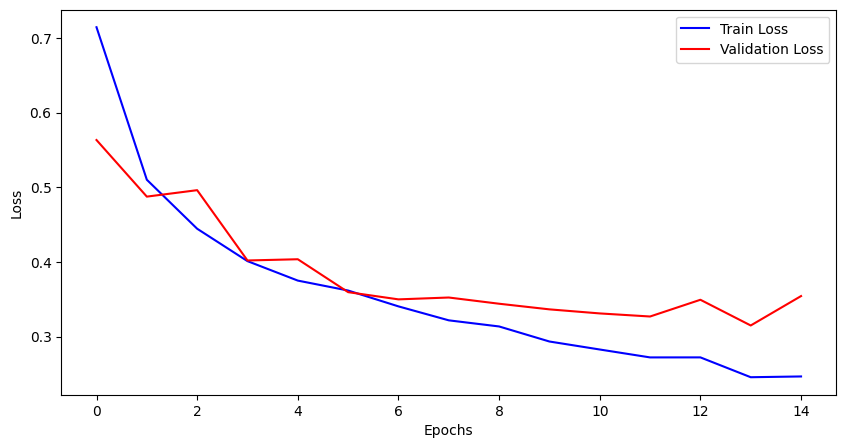

In [10]:
#plot train_loss and val_loss from the array 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


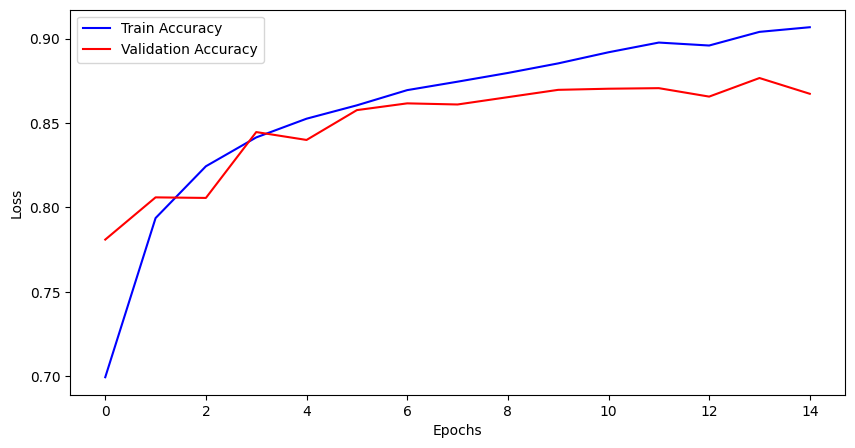

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
def evaluate_model_test(model , test_loader):
    #this function will evaluate the model on the test data
    model.eval()
    correct = 0
    total = 0
    predictions = []
    ground_truth=[]
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        ground_truth.extend(labels.cpu().numpy())
    accuracy = accuracy_score(ground_truth, predictions)
    return (accuracy, predictions, ground_truth)

Testing:  11%|█         | 5/47 [00:00<00:00, 49.54it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  36%|███▌      | 17/47 [00:00<00:00, 51.33it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  60%|█████▉    | 28/47 [00:00<00:00, 46.75it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  85%|████████▌ | 40/47 [00:00<00:00, 49.02it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing: 100%|██████████| 47/47 [00:00<00:00, 49.43it/s]


Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])
Test Accuracy: 0.8727


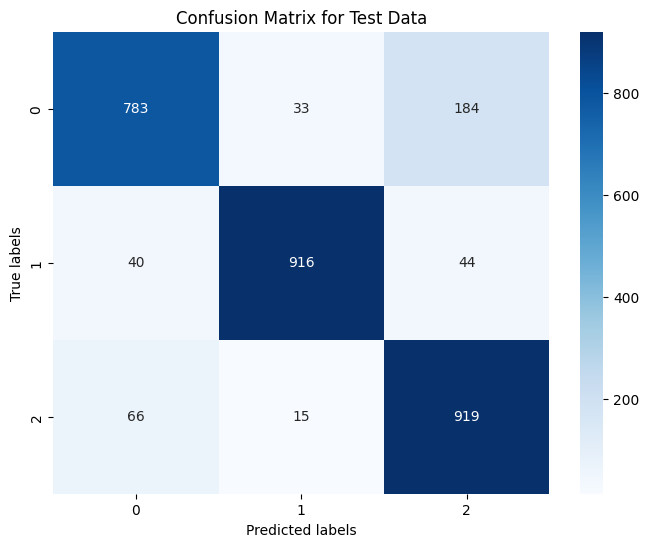

F1 Score: 0.8726


In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
data1= evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {data1[0]:.4f}")
predictions = data1[1]
ground_truth = data1[2]
confusion_matrix1= confusion_matrix(ground_truth, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix1, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Test Data')
plt.show()
f1_score = f1_score(ground_truth, predictions, average='macro')
print(f"F1 Score: {f1_score:.4f}")



Testing:  11%|█         | 5/47 [00:00<00:00, 46.55it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  34%|███▍      | 16/47 [00:00<00:00, 47.92it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Testing:  55%|█████▌    | 26/47 [00:00<00:00, 47.93it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  79%|███████▊  | 37/47 [00:00<00:00, 47.84it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing: 100%|██████████| 47/47 [00:00<00:00, 49.05it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([56, 16, 14, 14])
Shape after pooling: torch.Size([56, 32, 4, 4])
Validation Accuracy: 0.8673


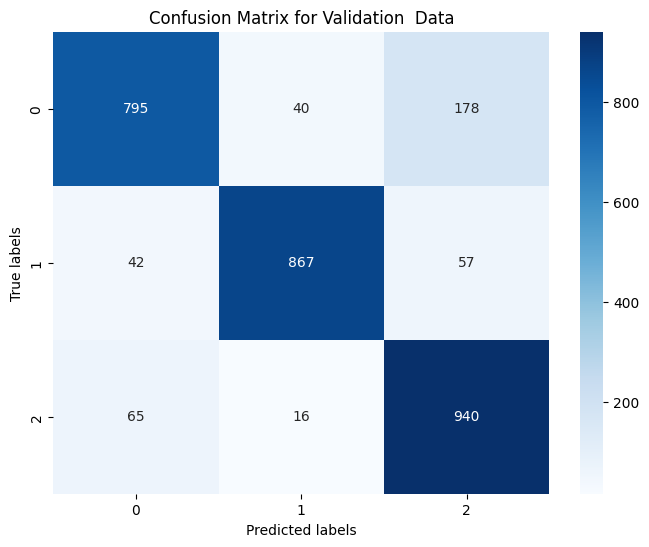

F1 Score for validation data is: 0.8681


In [14]:
from sklearn.metrics import f1_score
data2= evaluate_model_test(model, val_loader)
print(f"Validation Accuracy: {data2[0]:.4f}")
predictions = data2[1]
ground_truth = data2[2]
confusion_matrix1= confusion_matrix(ground_truth, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix1, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Validation  Data')
plt.show()
f1_score = f1_score(ground_truth, predictions, average='macro')
print(f"F1 Score for validation data is: {f1_score:.4f}")


Testing:   3%|▎         | 5/188 [00:00<00:04, 44.10it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:   9%|▊         | 16/188 [00:00<00:03, 49.34it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  14%|█▍        | 27/188 [00:00<00:03, 49.09it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  20%|██        | 38/188 [00:00<00:03, 49.26it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  27%|██▋       | 50/188 [00:01<00:02, 49.07it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Testing:  33%|███▎      | 62/188 [00:01<00:02, 51.45it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  36%|███▌      | 68/188 [00:01<00:02, 52.28it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  43%|████▎     | 80/188 [00:01<00:01, 55.29it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  49%|████▉     | 92/188 [00:01<00:01, 54.14it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  52%|█████▏    | 98/188 [00:01<00:01, 54.50it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])


Testing:  59%|█████▊    | 110/188 [00:02<00:01, 50.04it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  66%|██████▌   | 124/188 [00:02<00:01, 56.46it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  72%|███████▏  | 136/188 [00:02<00:00, 53.67it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  79%|███████▊  | 148/188 [00:02<00:00, 50.70it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  82%|████████▏ | 154/188 [00:02<00:00, 51.78it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  88%|████████▊ | 166/188 [00:03<00:00, 49.74it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing:  95%|█████████▍| 178/188 [00:03<00:00, 50.97it/s]

Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14]

Testing: 100%|██████████| 188/188 [00:03<00:00, 51.35it/s]

Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([64, 16, 14, 14])
Shape after pooling: torch.Size([64, 32, 4, 4])
Shape after  first pooling: torch.Size([32, 16, 14, 14])
Shape after pooling: torch.Size([32, 32, 4, 4])
Train Accuracy: 0.9053


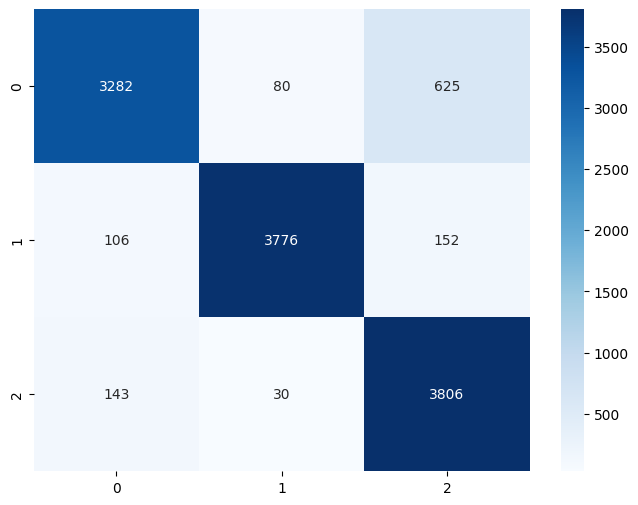

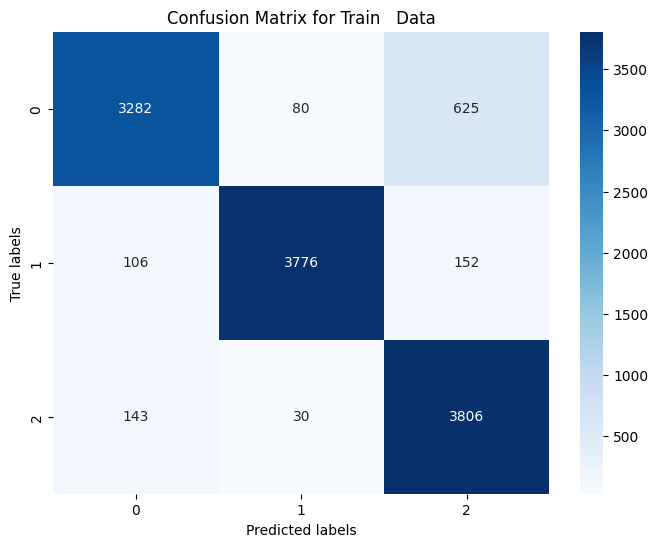

F1 Score for Train  data is: 0.9052


In [15]:
from sklearn.metrics import f1_score
data1= evaluate_model_test(model, train_loader)
print(f"Train Accuracy: {data1[0]:.4f}")
predictions = data1[1]
ground_truth = data1[2]
confusion_matrix1= confusion_matrix(ground_truth, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix1, annot=True, fmt='d', cmap='Blues')
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix1, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Train   Data')
plt.show()
f1_score = f1_score(ground_truth, predictions, average='macro')
print(f"F1 Score for Train  data is: {f1_score:.4f}")



In [16]:
class SimpleMLP(nn.Module):
    def __init__(self ):
        super(SimpleMLP, self).__init__()
        self.first_layer1 = nn.Linear(3*32*32 , 64) # the size of the input is 3*32*32 
        self.second_layer= nn.Linear(64, 3) # the output would be just 3 classes 
    def forward(self , x): 
        # x is the image sample  
        #x= x.view(-1 , 3*32*32) #flattens the image 
        x= torch.flatten(x, 1)
        x = F.relu(self.first_layer1(x))
        x= self.second_layer(x)
        return x
model= SimpleMLP()
print(model)

SimpleMLP(
  (first_layer1): Linear(in_features=3072, out_features=64, bias=True)
  (second_layer): Linear(in_features=64, out_features=3, bias=True)
)


Epoch 15/15 - Validation: 100%|██████████| 47/47 [00:01<00:00, 40.98it/s]


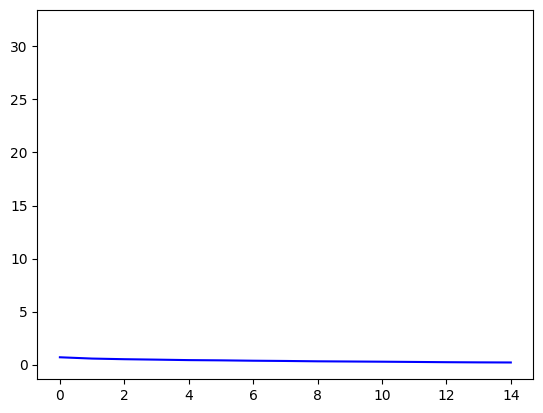

In [17]:
loss_function = nn.CrossEntropyLoss()
num_epochs = 15
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loss = []
val_losses=[]
training_accuracy = []
val_accuracy = []
for curr_epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total_loss = 0
    total = 0
    for image, label in tqdm(train_loader, desc=f"Epoch {curr_epoch+1}/{num_epochs} - Training"):
         #each image and label is   a tensor of batch size 
         image , label = image.to(device) ,label.to(device)
         optimizer.zero_grad() # clear the previous gradients
         outputs= model(image)
         loss = criterion(outputs, label)  # Compute los
       
         loss.backward()
         optimizer.step()
         total_loss+= loss.item()
         _, predicted = torch.max(outputs, 1)
         correct+=(predicted == label).sum().item()
         total+= label.size(0)
         #training_loss.append(total_loss/len(train_loader))
         #training_accuracy.append(correct/total)
    training_loss.append(total_loss/len(train_loader))
    training_accuracy.append(correct/total)   
    model.eval()
    val_loss=0
    val_correct=0
    val_total=0
    with torch.no_grad():  # Disable gradient computation for efficiency
        for image, label in tqdm(val_loader, desc=f"Epoch {curr_epoch+1}/{num_epochs} - Validation"):
            image, label = image.to(device), label.to(device)
            outputs = model(image)
            loss = loss_function(outputs, label)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == label).sum().item()
            val_total += label.size(0)
    val_losses.append(val_loss/len(val_loader))
    val_accuracy.append(val_correct/val_total)

#plot train_loss and val_loss from the array
# Plot the training and validation loss
torch.save(model.state_dict(), "mlp_model.pth")
plt.plot(training_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red') 
plt.show()


In [18]:
print("training loss is" , training_loss)
print("val loss is ", val_losses)

training loss is [0.6907112457333727, 0.5683910854636355, 0.5084322348554083, 0.4679410735818934, 0.42327287618784193, 0.4009013959860548, 0.3660339052848359, 0.3427663875070024, 0.31030671781999, 0.29209258217126766, 0.27338884073369046, 0.2508850577188299, 0.22707393682224952, 0.2101609855295813, 0.20014449591411554]
val loss is  [0.6903477374543535, 0.6185967890506096, 0.5726949173085233, 0.573544941684033, 0.5659748176310925, 0.5689242754844909, 0.5924977964543282, 0.6368542300893906, 0.5932214095237407, 0.6155353575310809, 0.6369916276728853, 0.6468878407427605, 0.7011978911592606, 0.7104129880032641, 0.6782776538995986]


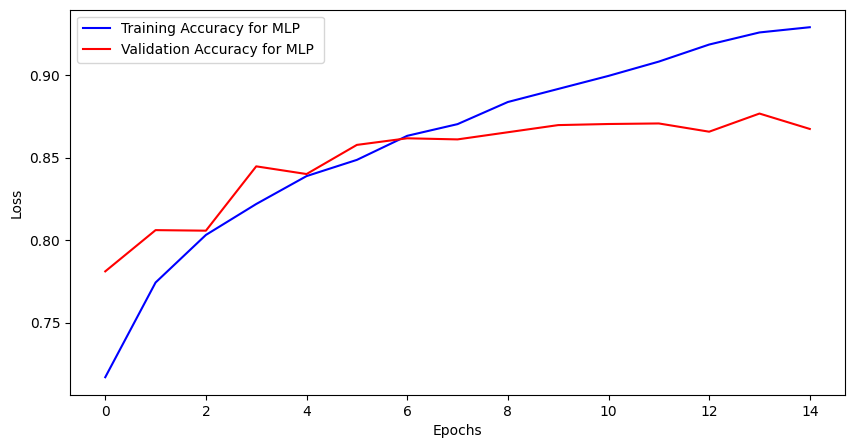

In [19]:
#plot train_loss and val_loss from the array 
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy for MLP', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy for MLP ', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

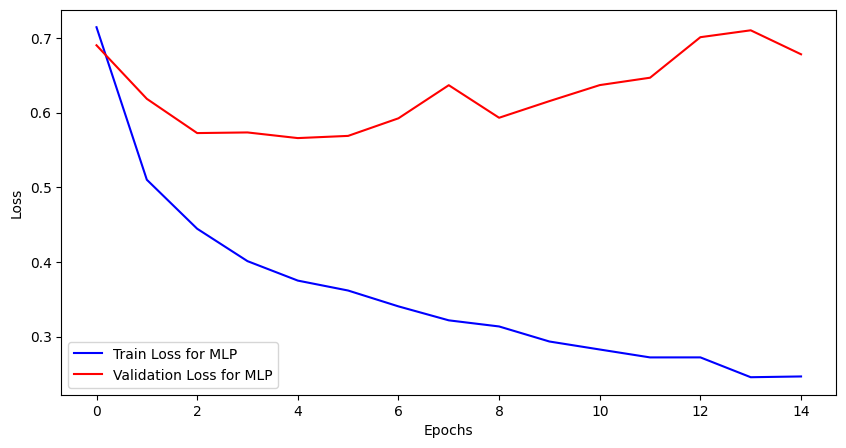

In [20]:
#plot train_loss and val_loss from the array 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss for MLP', color='blue')
plt.plot(val_losses, label='Validation Loss for MLP', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Testing: 100%|██████████| 47/47 [00:01<00:00, 28.06it/s]


Test Accuracy: 0.8117
F1 Score: 0.8113


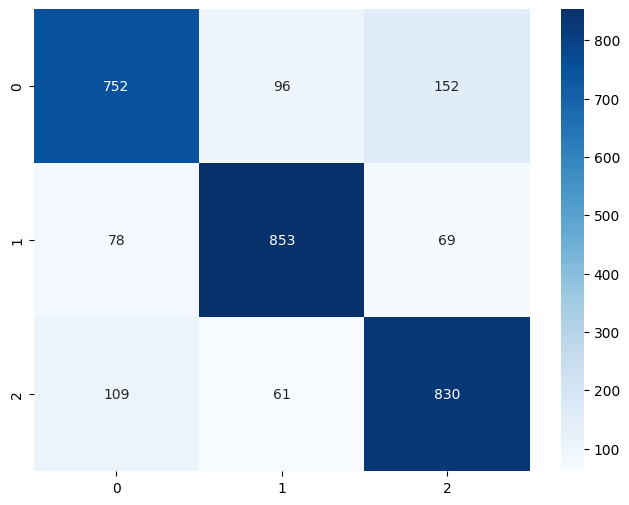

In [21]:
from sklearn.metrics import f1_score
data1= evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {data1[0]:.4f}")
predictions = data1[1]
ground_truth = data1[2]
confusion_matrix1= confusion_matrix(ground_truth, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix1, annot=True, fmt='d', cmap='Blues')
f1_score_Val = f1_score(ground_truth, predictions, average='macro')
print(f"F1 Score: {f1_score_Val:.4f}")
